# DMML - Assignment 2

Name: Alena Maria Thomas

Roll No: MDS202303

### Import all required libraries

In [2]:
! pip install -U memory_profiler

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import memory_profiler

from sklearn.metrics import pairwise_distances

In [4]:
%load_ext memory_profiler

### Define functions to perform K-Means clustering using Jaccard distance

In [5]:
def iter_Centroids(prev_centroids, clusters, n_clusters, data):
    '''
    Update the centroids based on the Jaccard distance between words within each cluster.
    '''
    centroids = []

    # find the index of the cluster element that has min dist with all others in the same cluster
    for i in range(n_clusters):
        col_sums = list(data.iloc[clusters[i],clusters[i]].sum(axis=0))
        min_index = np.argmin(col_sums)
        new_centre = clusters[i][min_index]
        centroids.append(new_centre)

    return centroids


def iter_Clusters(centroids, n_clusters, data):
    '''
    Assign data points to the clusters based on Jaccard distance from a given set of centroids
    '''
    clusters = [[] for _ in range(n_clusters)]

    # find the closest centroid to each data point and assign to corr cluster
    for i in range(data.shape[0]):
        dist = [data.iloc[i, centroids[j]] for j in range(n_clusters)]
        n = np.argmin(dist)
        clusters[n] += [i]

    return clusters


def inertia_calc(centroids, clusters, n_clusters, data):
    '''
    Calculate the inertia, which is a measure of how compact the clusters are.
    '''
    #print(centroids, clusters, n_clusters)
    iner_sum = 0
    for i in range(n_clusters):
        centroid_index = centroids[i]
        cluster_index = clusters[i]
        iner_sum += sum(data.iloc[cluster_index, centroid_index] ** 2)
    inertia = iner_sum / n_clusters

    return inertia


def Jacc_KMeans(data, n_clusters=3, max_iter=100, tol=1e-4, random_state=69):
    '''
    Performs KMeans clustering using Jaccard distance

    Returns: a list of centroids and a list of clusters
    '''
    np.random.seed(random_state)

    # generate 'k' random nos between 1 and n - these are the 'k' initial centroids
    n = len(data)
    centroids = np.random.choice(n, n_clusters, replace=False)

    # Brute-force the K Means algorithm
    for i in range(max_iter):
        clusters = iter_Clusters(centroids, n_clusters, data)
        new_centroids = iter_Centroids(centroids, clusters, n_clusters, data)

        # check for convergence based on change in inertia
        inertia_1 = inertia_calc(centroids, clusters, n_clusters, data)
        inertia_2 = inertia_calc(new_centroids, clusters, n_clusters, data)
        if np.abs(inertia_1 - inertia_2) < tol:
            break

        centroids = new_centroids

    clusters = iter_Clusters(centroids, n_clusters, data)

    return (centroids, clusters)


def elbow_plot(data, max_clusters, data_name=""):
    '''
    Plot an elbow plot for the given dataset
    '''
    inertia_list = []

    for k in range(1, max_clusters+1):
        # Perform KMeans clustering
        centroids, clusters = Jacc_KMeans(data=data, n_clusters=k)
        # Calculate inertia
        iner = inertia_calc(centroids, clusters, k, data)
        inertia_list.append(iner)

    # Plot the elbow plot
    plt.plot(range(1, max_clusters+1), inertia_list, marker='o')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow plot for {0} dataset'.format(data_name))
    plt.show()

## **KOS dataset**

#### 1. Load the KOS dataset.

In [5]:
kos_data = pd.read_csv('/content/docword.kos.txt', skiprows=3, sep=' ', header=None)
kos_data.columns = ['docID', 'wordID', 'count']
kos_data

,docID,wordID,count
0,1,61,2
1,1,76,1
2,1,89,1
3,1,211,1
4,1,296,1
...,...,...,...
353155,3430,6328,1
353156,3430,6644,1
353157,3430,6741,1
353158,3430,6799,1


#### 2. Create a sparse matrix of the dataset.

In [6]:
doc_Count = kos_data["docID"].nunique()
word_Count = kos_data["wordID"].nunique()

kos_matrix = np.zeros((word_Count+1, doc_Count+1))
for j in range(kos_data.shape[0]):
    kos_matrix[int(kos_data['wordID'][j]), int(kos_data['docID'][j])] = 1

#### 3. Compute the Jaccard distance matrix.

In [7]:
%%time
%%memit
j_kos = pairwise_distances(np.transpose(kos_matrix), metric='jaccard')
kos_jacc_dist_mat = pd.DataFrame(j_kos)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


peak memory: 606.28 MiB, increment: 249.37 MiB
CPU times: user 7min 51s, sys: 876 ms, total: 7min 52s
Wall time: 8min 2s


In [8]:
kos_jacc_dist_mat

,0,1,2,3,4,5,6,7,8,9,...,3421,3422,3423,3424,3425,3426,3427,3428,3429,3430
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.0,0.000000,0.933333,0.964602,0.957219,0.919283,0.960938,0.938650,0.962963,0.777778,...,0.961957,0.954545,0.956522,0.971631,0.953333,0.927007,0.923729,0.957831,0.980892,0.970414
2,1.0,0.933333,0.000000,0.937143,0.972028,0.951087,0.950617,0.931624,0.966292,0.945946,...,0.948529,0.968326,0.926829,0.922222,0.941748,0.935484,0.932432,0.966942,0.972477,0.975610
3,1.0,0.964602,0.937143,0.000000,0.967290,0.948819,0.960784,0.952632,0.949367,0.956284,...,0.961722,0.303371,0.956790,0.963636,0.966102,0.945122,0.966216,0.968912,0.966667,0.974359
4,1.0,0.957219,0.972028,0.967290,0.000000,0.842640,0.983051,0.967742,0.975806,0.986667,...,0.965116,0.964567,0.976027,0.968750,0.971429,0.969231,0.982143,0.967742,0.972028,0.967949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3426,1.0,0.927007,0.935484,0.945122,0.969231,0.947368,0.909091,0.901961,0.902778,0.869565,...,0.976378,0.946078,0.967078,0.909091,0.857143,0.000000,0.653061,0.933333,0.923913,0.933962
3427,1.0,0.923729,0.932432,0.966216,0.982143,0.947368,0.893617,0.891566,0.907407,0.894737,...,0.971963,0.968254,0.968750,0.933333,0.898551,0.653061,0.000000,0.878049,0.946667,0.943182
3428,1.0,0.957831,0.966942,0.968912,0.967742,0.948980,0.968421,0.954545,0.970588,0.968254,...,0.973684,0.970085,0.962547,0.952381,0.939130,0.933333,0.878049,0.000000,0.737374,0.970370
3429,1.0,0.980892,0.972477,0.966667,0.972028,0.956757,0.937500,0.975410,0.954545,0.964602,...,0.963768,0.963636,0.976744,0.956989,0.951923,0.923913,0.946667,0.737374,0.000000,0.714286


#### 4. Plot the elbow graph.

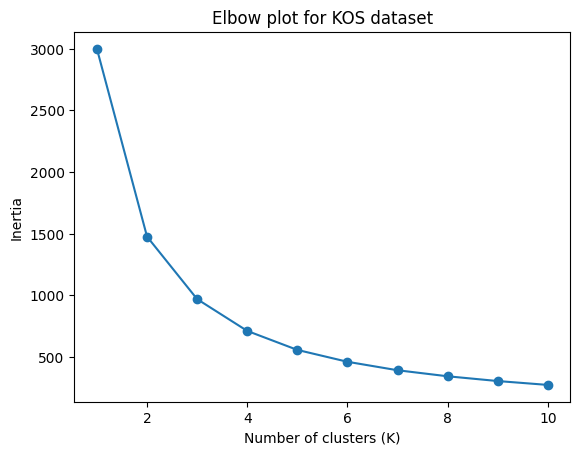

peak memory: 615.45 MiB, increment: 166.87 MiB
CPU times: user 27.2 s, sys: 1.2 s, total: 28.4 s
Wall time: 28.2 s


In [9]:
%%time
%%memit
elbow_plot(kos_jacc_dist_mat, 10, 'KOS')

#### Observation:

The optimal number of clusters (K) for the KOS dataset is 2.

## **NIPS dataset**

#### 1. Load the NIPS dataset.

In [10]:
nips_data = pd.read_csv('/content/docword.nips.txt', skiprows=3, sep=' ', header=None)
nips_data.columns = ['docID', 'wordID', 'count']
nips_data

,docID,wordID,count
0,1,2,1
1,1,39,1
2,1,42,3
3,1,77,1
4,1,95,1
...,...,...,...
746311,1500,12382,1
746312,1500,12388,3
746313,1500,12390,1
746314,1500,12393,1


#### 2. Create a sparse matrix of the dataset.

In [11]:
doc_Count = nips_data["docID"].nunique()
word_Count = nips_data["wordID"].max()

nips_matrix = np.zeros((word_Count+1, doc_Count+1))
for j in range(nips_data.shape[0]):
    nips_matrix[int(nips_data['wordID'][j]), int(nips_data['docID'][j])] = 1

#### 3. Compute the Jaccard distance matrix.

In [12]:
%%time
%%memit
j_nips = pairwise_distances(np.transpose(nips_matrix), metric='jaccard')
nips_jacc_dist_mat = pd.DataFrame(j_nips)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


peak memory: 857.73 MiB, increment: 142.43 MiB
CPU times: user 2min 18s, sys: 322 ms, total: 2min 18s
Wall time: 2min 19s


#### 4. Plot the elbow graph.

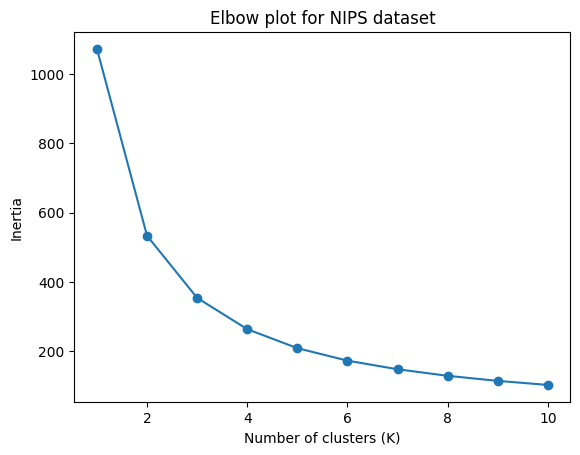

peak memory: 770.03 MiB, increment: 37.34 MiB
CPU times: user 8.9 s, sys: 483 ms, total: 9.38 s
Wall time: 9.45 s


In [13]:
%%time
%%memit
elbow_plot(nips_jacc_dist_mat, 10, 'NIPS')

#### Observation:

The optimal number of clusters (K) for the NIPS dataset is 2.

## **Enron dataset**

#### 1. Load the Enron dataset.

Since the Enron dataset is very large, we pick out the documents with more than 200 distinct words, and work on it.

In [6]:
enron_df = pd.read_csv('/content/docword.enron.txt', skiprows=3, sep=' ', header=None)
enron_df.columns = ['docID', 'wordID', 'count']
enron_df.shape

(3710420, 3)

In [7]:
df1 = enron_df['docID'].value_counts().to_frame().reset_index()
df1.columns = ["docID","freq"]
df2 = df1[df1["freq"]>200] #docs with more than 200 distinct words ignoring the multiplicity of a word
df2

,docID,freq
0,30671,2120
1,33962,2120
2,31445,2075
3,28980,2050
4,33931,2050
...,...,...
3648,26667,201
3649,27598,201
3650,12894,201
3651,9272,201


In [8]:
doclist=df2["docID"].to_numpy()

In [9]:
doc_dict = {}
for i in range(enron_df.shape[0]):
  doc_index = enron_df.docID[i]
  if doc_index in doclist:
    if doc_index in doc_dict.keys():
      doc_dict[doc_index].append(enron_df.wordID[i])
    else:
      doc_dict[doc_index] = [enron_df.wordID[i]]

#### 2. Create a sparse matrix of the dataset.

In [10]:
doc_Count = len(doclist)
word_Count = max(enron_df["wordID"])

enron_matrix = np.zeros((word_Count, doc_Count))
doc_pointer = 0
for doc_index in doc_dict:
  for word_index in doc_dict[doc_index]:
    enron_matrix[word_index-1][doc_pointer] = 1
  doc_pointer+=1

#### 3. Compute the Jaccard distance matrix.

In [12]:
%%time
%%memit
j_enron = pairwise_distances(np.transpose(enron_matrix), metric='jaccard')
enron_jacc_dist_mat = pd.DataFrame(j_enron)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


peak memory: 1826.32 MiB, increment: 934.98 MiB
CPU times: user 1h 14min 32s, sys: 5.49 s, total: 1h 14min 38s
Wall time: 1h 15min 9s


In [13]:
enron_jacc_dist_mat

,0,1,2,3,4,5,6,7,8,9,...,3643,3644,3645,3646,3647,3648,3649,3650,3651,3652
0,0.000000,0.935733,0.931818,0.935733,0.951282,0.952174,0.937788,0.955335,0.930526,0.959900,...,0.964876,0.966667,0.934596,0.969048,0.964523,0.929705,0.929062,0.943694,0.968134,0.955381
1,0.935733,0.000000,0.929825,0.000000,0.949109,0.943478,0.964365,0.950617,0.864745,0.933842,...,0.956612,0.962891,0.936860,0.920988,0.964835,0.920635,0.922374,0.958150,0.949309,0.940397
2,0.931818,0.929825,0.000000,0.929825,0.952854,0.953488,0.965066,0.951691,0.949597,0.924623,...,0.959514,0.965517,0.932432,0.965197,0.954248,0.929360,0.926339,0.954447,0.945205,0.947984
3,0.935733,0.000000,0.929825,0.000000,0.949109,0.943478,0.964365,0.950617,0.864745,0.933842,...,0.956612,0.962891,0.936860,0.920988,0.964835,0.920635,0.922374,0.958150,0.949309,0.940397
4,0.951282,0.949109,0.952854,0.949109,0.000000,0.931111,0.925234,0.942065,0.945946,0.943878,...,0.933902,0.974659,0.952542,0.948905,0.936073,0.943946,0.943439,0.936364,0.963359,0.942819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,0.929705,0.920635,0.929360,0.920635,0.943946,0.959847,0.954000,0.931416,0.940520,0.942350,...,0.943715,0.944444,0.912141,0.960084,0.952475,0.000000,0.022388,0.944334,0.935438,0.945946
3649,0.929062,0.922374,0.926339,0.922374,0.943439,0.961538,0.953629,0.930804,0.940075,0.941834,...,0.943289,0.944043,0.913323,0.959746,0.952096,0.022388,0.000000,0.948104,0.935065,0.948276
3650,0.943694,0.958150,0.954447,0.958150,0.936364,0.945419,0.949495,0.951965,0.959633,0.949002,...,0.931298,0.968310,0.935636,0.946467,0.964567,0.944334,0.948104,0.000000,0.969317,0.914975
3651,0.968134,0.949309,0.945205,0.949309,0.963359,0.974079,0.966054,0.973254,0.964048,0.976084,...,0.951020,0.954068,0.947929,0.970717,0.950142,0.935438,0.935065,0.969317,0.000000,0.950787


#### 4. Plot the elbow graph.

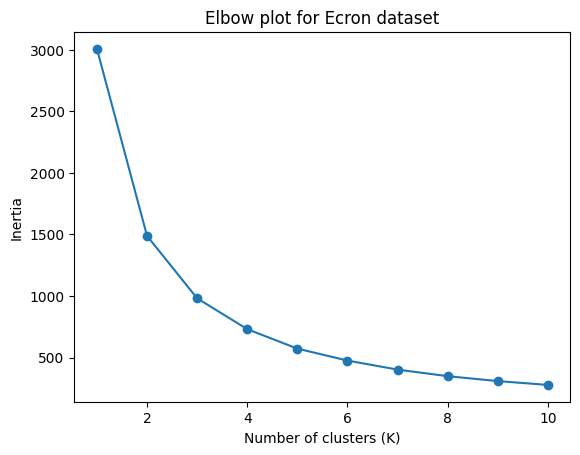

peak memory: 1117.41 MiB, increment: 120.82 MiB
CPU times: user 25.8 s, sys: 1.47 s, total: 27.3 s
Wall time: 27.2 s


In [14]:
%%time
%%memit
elbow_plot(enron_jacc_dist_mat, 10, 'Ecron')

#### Observation:

The optimal number of clusters (K) for the Enron dataset is 2.